#Numpy and Scipy Implementation of Physics-Informed Gaussian Process

Scientific Machine Learning Workshop at Cenpes 2025<br>
This code is distributed under the GNU LGPL license.<br>
Last Modified: Aug 2025<br>

This python script demonstrates coding and training a physics-informed Gaussian process to solve the classical univariate advection of a tracer in a moving fluid, with a sinusoidal initial condition.

The evolution of the tracer concentration $q(x,t)$ in a pipe, for $0 \leq x \leq L$ and $t>0$, is governed by the univariate linear advection hyperbolic PDE:
  \begin{aligned}
  q_t + vq_x = 0
  \end{aligned}
where $v$ is the constant velocity. The initial condition is  
\begin{equation}
  q(x,0) = \sin(x)
\end{equation}
This simple problem has as solution:
\begin{aligned}
     q(x,t) = \sin(x-vt)
  \end{aligned}
In other words, the initial sinusoisal profile is simply advected to the left with speed $v$.

We assume $L = 16\pi$ and $v = 10$.

In [1]:
"""
Import libraries
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve
from scipy.optimize import minimize
from scipy.stats.qmc import LatinHypercube as lhs

In [2]:
"""
Problem definition and training data
"""

# parameters of the simulation
A =  1            # amplitude of sinusoisal
xl = 0            # left limit of interval
xr = 16*np.pi     # right limit of interval
ti = 0.0          # initial time
tf = 1.0          # final time
v = 10            # advection speed
delta = 0.000001  # small value to add to the diagonal of K2

# training points (initial + boundary condition points)
Np = [100,100]
N = np.sum(Np)
x = np.concatenate((np.linspace(xl,xr,Np[1]),xl*np.ones(Np[0])))
t = np.concatenate((ti*np.ones(Np[1]),np.linspace(ti,tf,Np[0])))
X = np.hstack((x[:,np.newaxis],t[:,np.newaxis]))

# training points (PDE residual points)
Nres = 800
Z = lhs(2).random(Nres)
Z[:,0] = xl+(xr-xl)*Z[:,0]
Z[:,1] = ti+(tf-ti)*Z[:,1]

# generate the training data responses
Y = np.zeros([N+Nres,1])
Y[0:Np[1],0] = A*np.sin(X[0:Np[1],0])
Y[Np[1]:N,0] = -A*np.sin(v*X[Np[1]:N,1])

In [3]:
"""
marginal likelihood function
"""
def mrglik(th,X,Y,Z,v):

    N = X.shape[0]
    Nres = Z.shape[0]

    # generate the K2 matrix
    K2 = np.zeros([N+Nres,N+Nres])
    for i in range(N):
        for j in range(N):
            K2[i,j] = th[0]*th[0] * \
            np.exp(-.5*np.power(X[i,0]-X[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-X[j,1],2)/th[2]/th[2])
        for j in range(Nres):
            K2[i,N+j] = th[0]*th[0]*((X[i,1]-Z[j,1])/th[2]/th[2]+v*(X[i,0]-Z[j,0])/th[1]/th[1]) * \
            np.exp(-.5*np.power(X[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-Z[j,1],2)/th[2]/th[2])
    for i in range(Nres):
        for j in range(N):
            K2[N+i,j] = K2[j,N+i]
        for j in range(Nres):
            K2[N+i,N+j] = th[0]*th[0]*(1/th[2]/th[2]+v*v/th[1]/th[1] - \
            np.power((Z[i,1]-Z[j,1])/th[2]/th[2]+v*(Z[i,0]-Z[j,0])/th[1]/th[1],2)) * \
            np.exp(-.5*np.power(Z[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(Z[i,1]-Z[j,1],2)/th[2]/th[2])

    # compute alpha
    L,low = cho_factor(K2+delta*np.eye(N+Nres))
    alpha = cho_solve((L,low),Y)

    return (0.5*Y.T.dot(alpha)+np.sum(np.log(np.diag(L)))+0.5*(N+Nres)*np.log(2*np.pi)).item()

def cb(intermediate_result):
    global Niter
    th = intermediate_result.x
    fun = intermediate_result.fun
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}' \
          .format(Niter,th[0],th[1],th[2],-fun))
    Niter += 1

In [ ]:
""""
PIGP training using direct implementation in numpy and scipy
"""

# initialize GP parameters [sigma,lsx,lst]
th = np.array([1,1,1])

Niter = 1
print('{0:4s}   {1:9s}   {2:9s}   {3:9s}   {4:9s}' \
      .format('Iter', ' sigma', ' ls_x', ' ls_t', ' mrglik'))
print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}' \
      .format(0,th[0],th[1],th[2],-mrglik(th,X,Y,Z,v)))
opt=minimize(mrglik,th,args=(X,Y,Z,v),method='L-BFGS-B',bounds=(((0.01,None),)*3),callback=cb)
if opt.success:
    print("Training finished successfully.")
else:
    print("Training failed.")
th = opt.x
mrglik_val = opt.fun
print("Final trained values:")
print("sigma  = {:.6f}".format(th[0]))
print("ls_x   = {:.6f}".format(th[1]))
print("ls_t   = {:.6f}".format(th[2]))
print("mrglik = {:.6f}".format(-mrglik_val))

Iter    sigma       ls_x        ls_t        mrglik  
   0    1.000000    1.000000    1.000000   -19528032.472317
   1    1.302839    1.000000    1.000000   -18164149.001586
   2    1.195956    0.964048    0.908123   -15589637.446351
   3    0.790273    0.637694    0.600899   -1468904.196769
   4    0.657842    0.609161    0.500610   -428710.934901
   5    0.534857    0.603654    0.392899   -65807.402543
   6    0.505120    0.611710    0.352970   -26224.410188
   7    0.487557    0.622614    0.318660   -10877.100196
   8    0.479202    0.632510    0.293485   -5714.275631
   9    0.474983    0.643190    0.269707   -3238.527751
  10    0.474755    0.655439    0.245633   -1919.569264
  11    0.479563    0.669736    0.221211   -1230.031785
  12    0.492164    0.685452    0.201366   -943.628467
  13    0.509521    0.700015    0.186213   -833.919878
  14    0.527056    0.714862    0.176753   -787.855030
  15    0.546611    0.738149    0.169305   -736.855155
  16    0.588350    0.810158    0.1

KeyboardInterrupt: 

In [5]:
"""
Prediction on test grid
"""

# previously found values
th = np.array([3.3078,2.6910,0.2377])

K2 = np.zeros([N+Nres,N+Nres])
#th = np.array([0.5238*, 0.0126, 0.0000, 0.0001])
for i in range(N):
    for j in range(N):
        K2[i,j] = th[0]*th[0] * \
        np.exp(-.5*np.power(X[i,0]-X[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-X[j,1],2)/th[2]/th[2])
    for j in range(Nres):
        K2[i,N+j] = th[0]*th[0]*((X[i,1]-Z[j,1])/th[2]/th[2]+v*(X[i,0]-Z[j,0])/th[1]/th[1]) * \
        np.exp(-.5*np.power(X[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-Z[j,1],2)/th[2]/th[2])
for i in range(Nres):
    for j in range(N):
        K2[N+i,j] = K2[j,N+i]
    for j in range(Nres):
        K2[N+i,N+j] = th[0]*th[0]*(1/th[2]/th[2]+v*v/th[1]/th[1] - \
        np.power((Z[i,1]-Z[j,1])/th[2]/th[2]+v*(Z[i,0]-Z[j,0])/th[1]/th[1],2)) * \
        np.exp(-.5*np.power(Z[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(Z[i,1]-Z[j,1],2)/th[2]/th[2])

# compute alpha
L,low = cho_factor(K2+delta*np.eye(N+Nres))
alpha = cho_solve((L,low),Y)

# compute images row by row
# due to computational cost of GP prediction
Mx = 400
Mt = 200 # image Mt x Mx
u = np.zeros([Mt,Mx])
u_pm = np.zeros([Mt,Mx])
u_sd = np.zeros([Mt,Mx])
for r,t_star in enumerate(np.linspace(ti,tf,Mt)): # time slice

    print("r = "+str(r))
    print("t_star = {:.2f}".format(t_star))

    xs = np.linspace(xl,xr,Mx)
    X_star = np.hstack((xs[:,np.newaxis],t_star*np.ones([Mx,1])))

    # generate the K0 matrix
    K0 = np.zeros([Mx,Mx])
    for i in range(Mx):
        for j in range(Mx):
            K0[i,j] = th[0]*th[0]*np.exp(-.5*np.power(X_star[i,0]-X_star[j,0],2)/th[1]/th[1] - \
                      .5*np.power(X_star[i,1]-X_star[j,1],2)/th[2]/th[2])

    # generate the K1 matrix
    K1 = np.zeros([Mx,N+Nres])
    for i in range(Mx):
        for j in range(N):
            K1[i,j] = th[0]*th[0]*np.exp(-.5*np.power(X_star[i,0]-X[j,0],2)/th[1]/th[1] - \
                      .5*np.power(X_star[i,1]-X[j,1],2)/th[2]/th[2])
        for j in range(Nres):
            K1[i,N+j] = th[0]*th[0]*((X_star[i,1]-Z[j,1])/th[2]/th[2]+v*(X_star[i,0]-Z[j,0])/th[1]/th[1]) * \
            np.exp(-.5*np.power(X_star[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(X_star[i,1]-Z[j,1],2)/th[2]/th[2])

    # analytical solution on test grid
    for i in range(Mx):
        u[r,i] = A*np.sin(X_star[i,0]-v*X_star[i,1])

    # predict on test
    u_pm[r,:] = K1.dot(alpha).flatten() # posterior mean
    w  = cho_solve((L,low),K1.T)
    Yc = K0 - K1.dot(w)
    u_sd[r,:] = np.sqrt(np.diag(Yc)).flatten() # posterior variance

r = 0
t_star = 0.00
r = 1
t_star = 0.01
r = 2
t_star = 0.01
r = 3
t_star = 0.02
r = 4
t_star = 0.02
r = 5
t_star = 0.03
r = 6
t_star = 0.03
r = 7
t_star = 0.04
r = 8
t_star = 0.04
r = 9
t_star = 0.05
r = 10
t_star = 0.05
r = 11
t_star = 0.06
r = 12
t_star = 0.06
r = 13
t_star = 0.07
r = 14
t_star = 0.07
r = 15
t_star = 0.08
r = 16
t_star = 0.08
r = 17
t_star = 0.09
r = 18
t_star = 0.09
r = 19
t_star = 0.10
r = 20
t_star = 0.10
r = 21
t_star = 0.11
r = 22
t_star = 0.11
r = 23
t_star = 0.12
r = 24
t_star = 0.12
r = 25
t_star = 0.13
r = 26
t_star = 0.13
r = 27
t_star = 0.14
r = 28
t_star = 0.14
r = 29
t_star = 0.15
r = 30
t_star = 0.15
r = 31
t_star = 0.16
r = 32
t_star = 0.16
r = 33
t_star = 0.17
r = 34
t_star = 0.17
r = 35
t_star = 0.18
r = 36
t_star = 0.18
r = 37
t_star = 0.19
r = 38
t_star = 0.19
r = 39
t_star = 0.20
r = 40
t_star = 0.20
r = 41
t_star = 0.21
r = 42
t_star = 0.21
r = 43
t_star = 0.22
r = 44
t_star = 0.22
r = 45
t_star = 0.23
r = 46
t_star = 0.23
r = 47
t_star = 0.24
r 

L2 error: 6.1588e-04


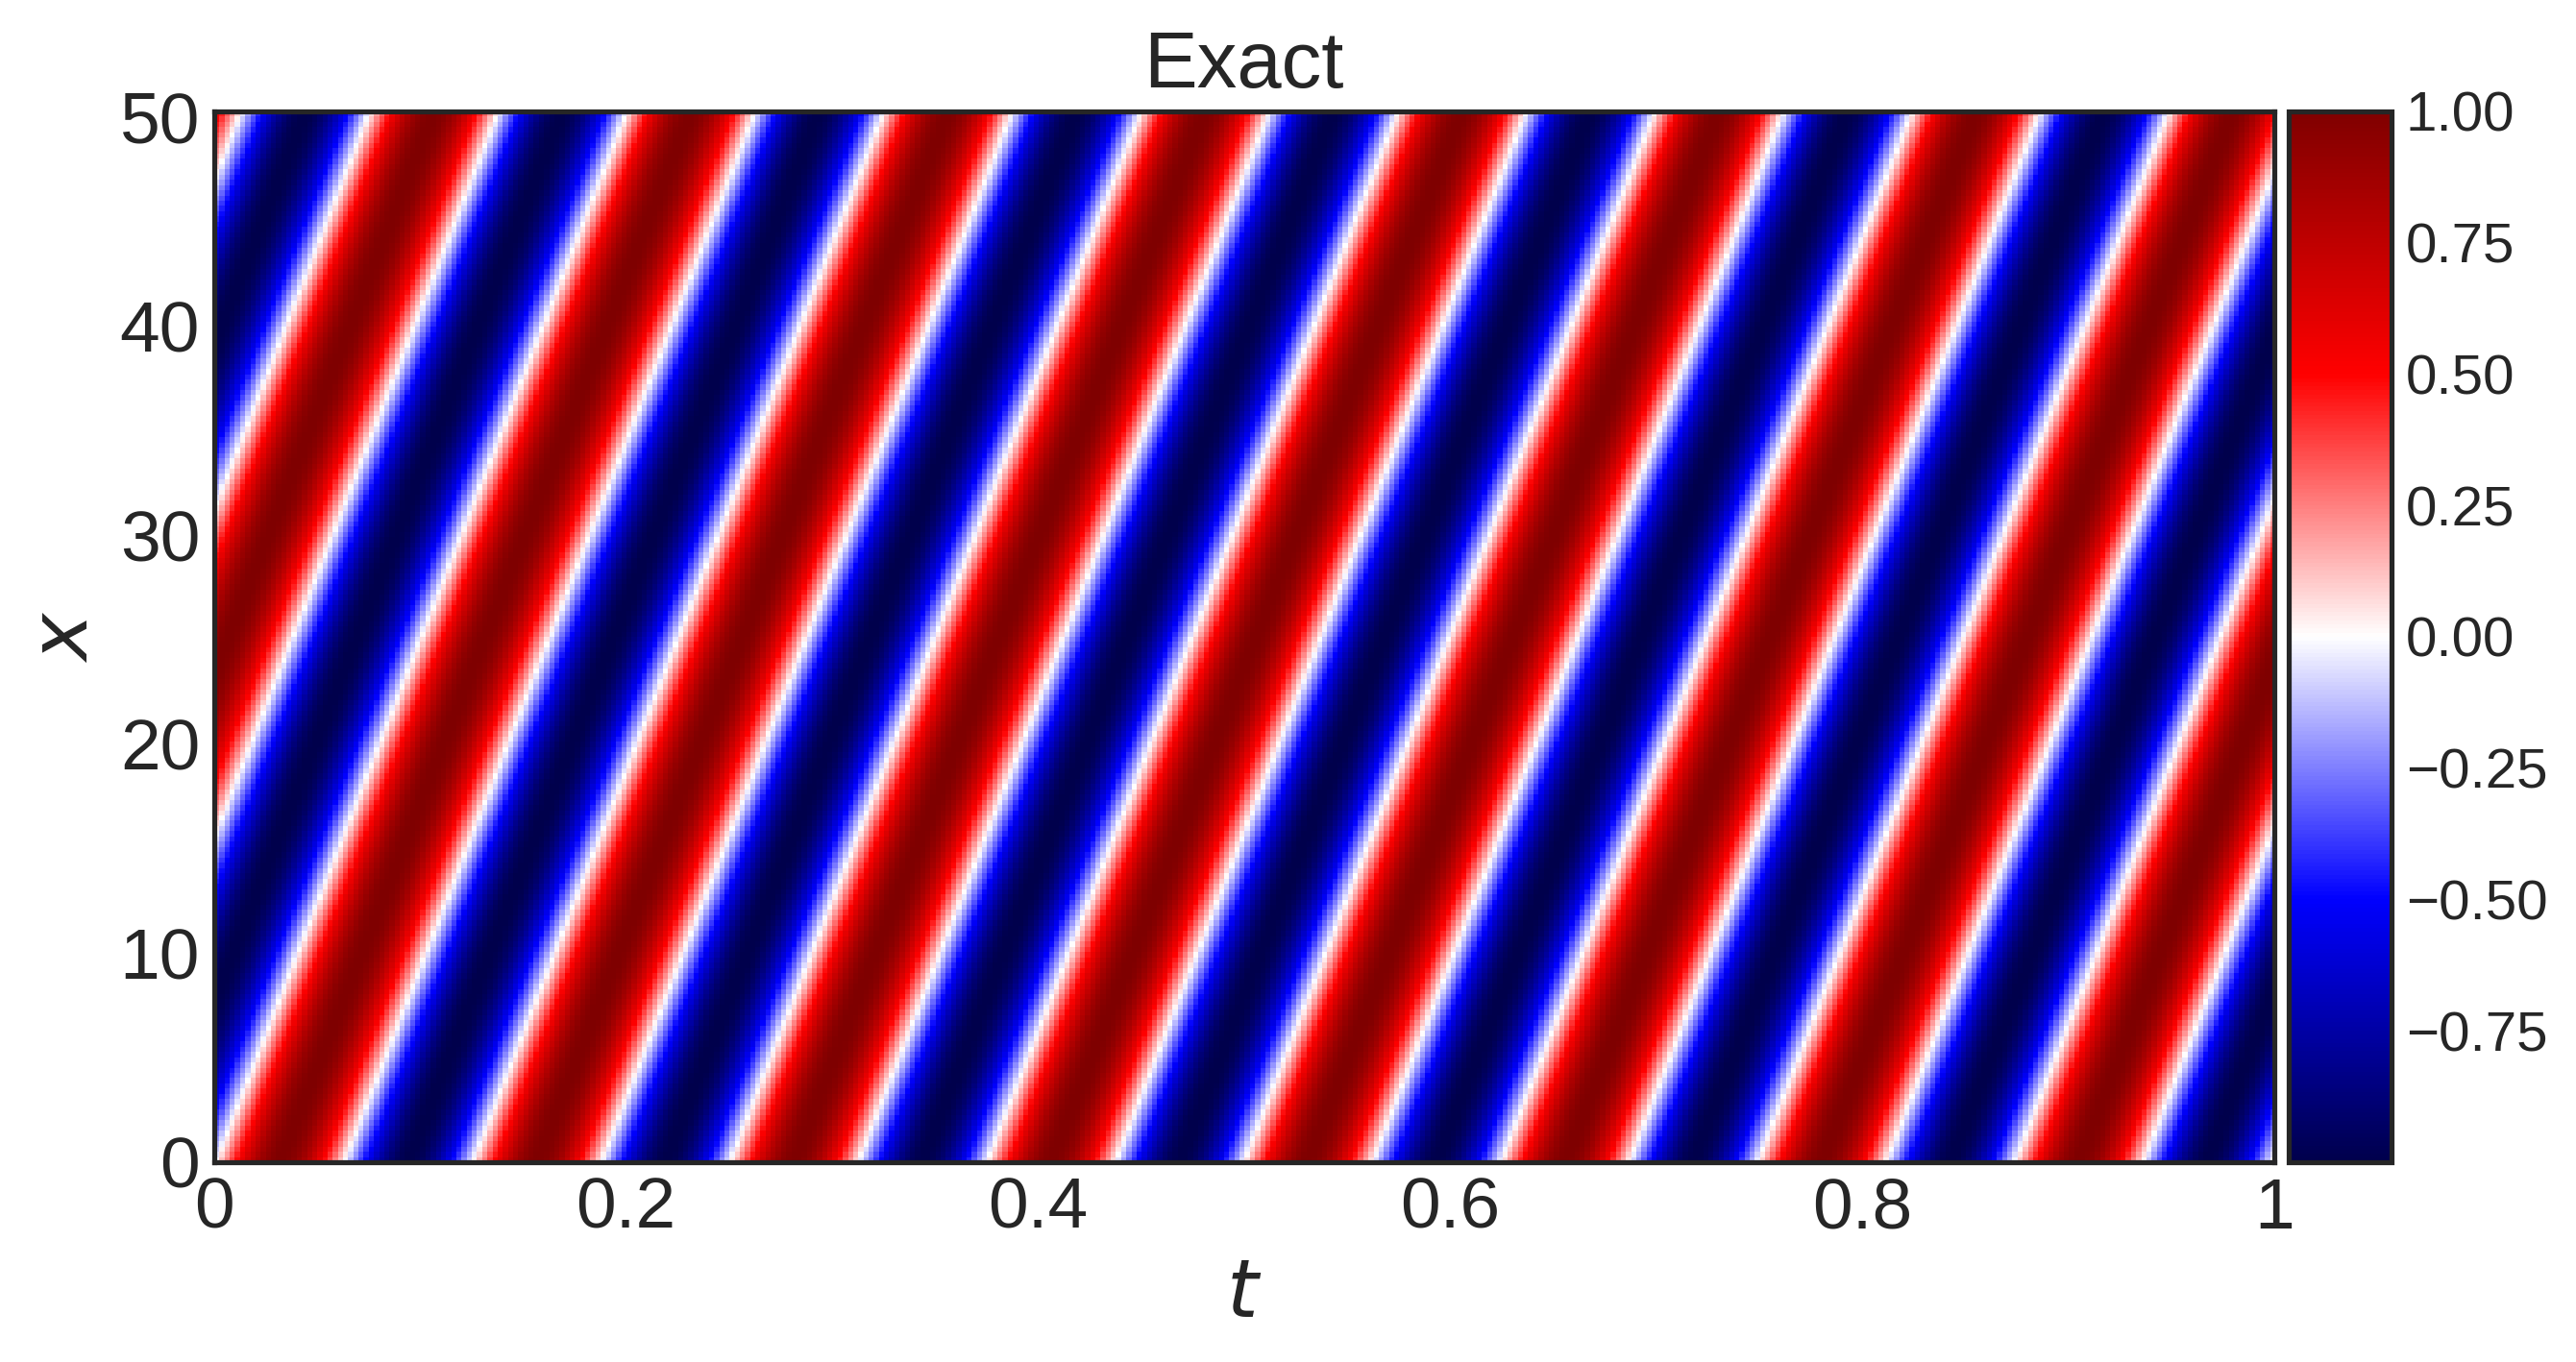

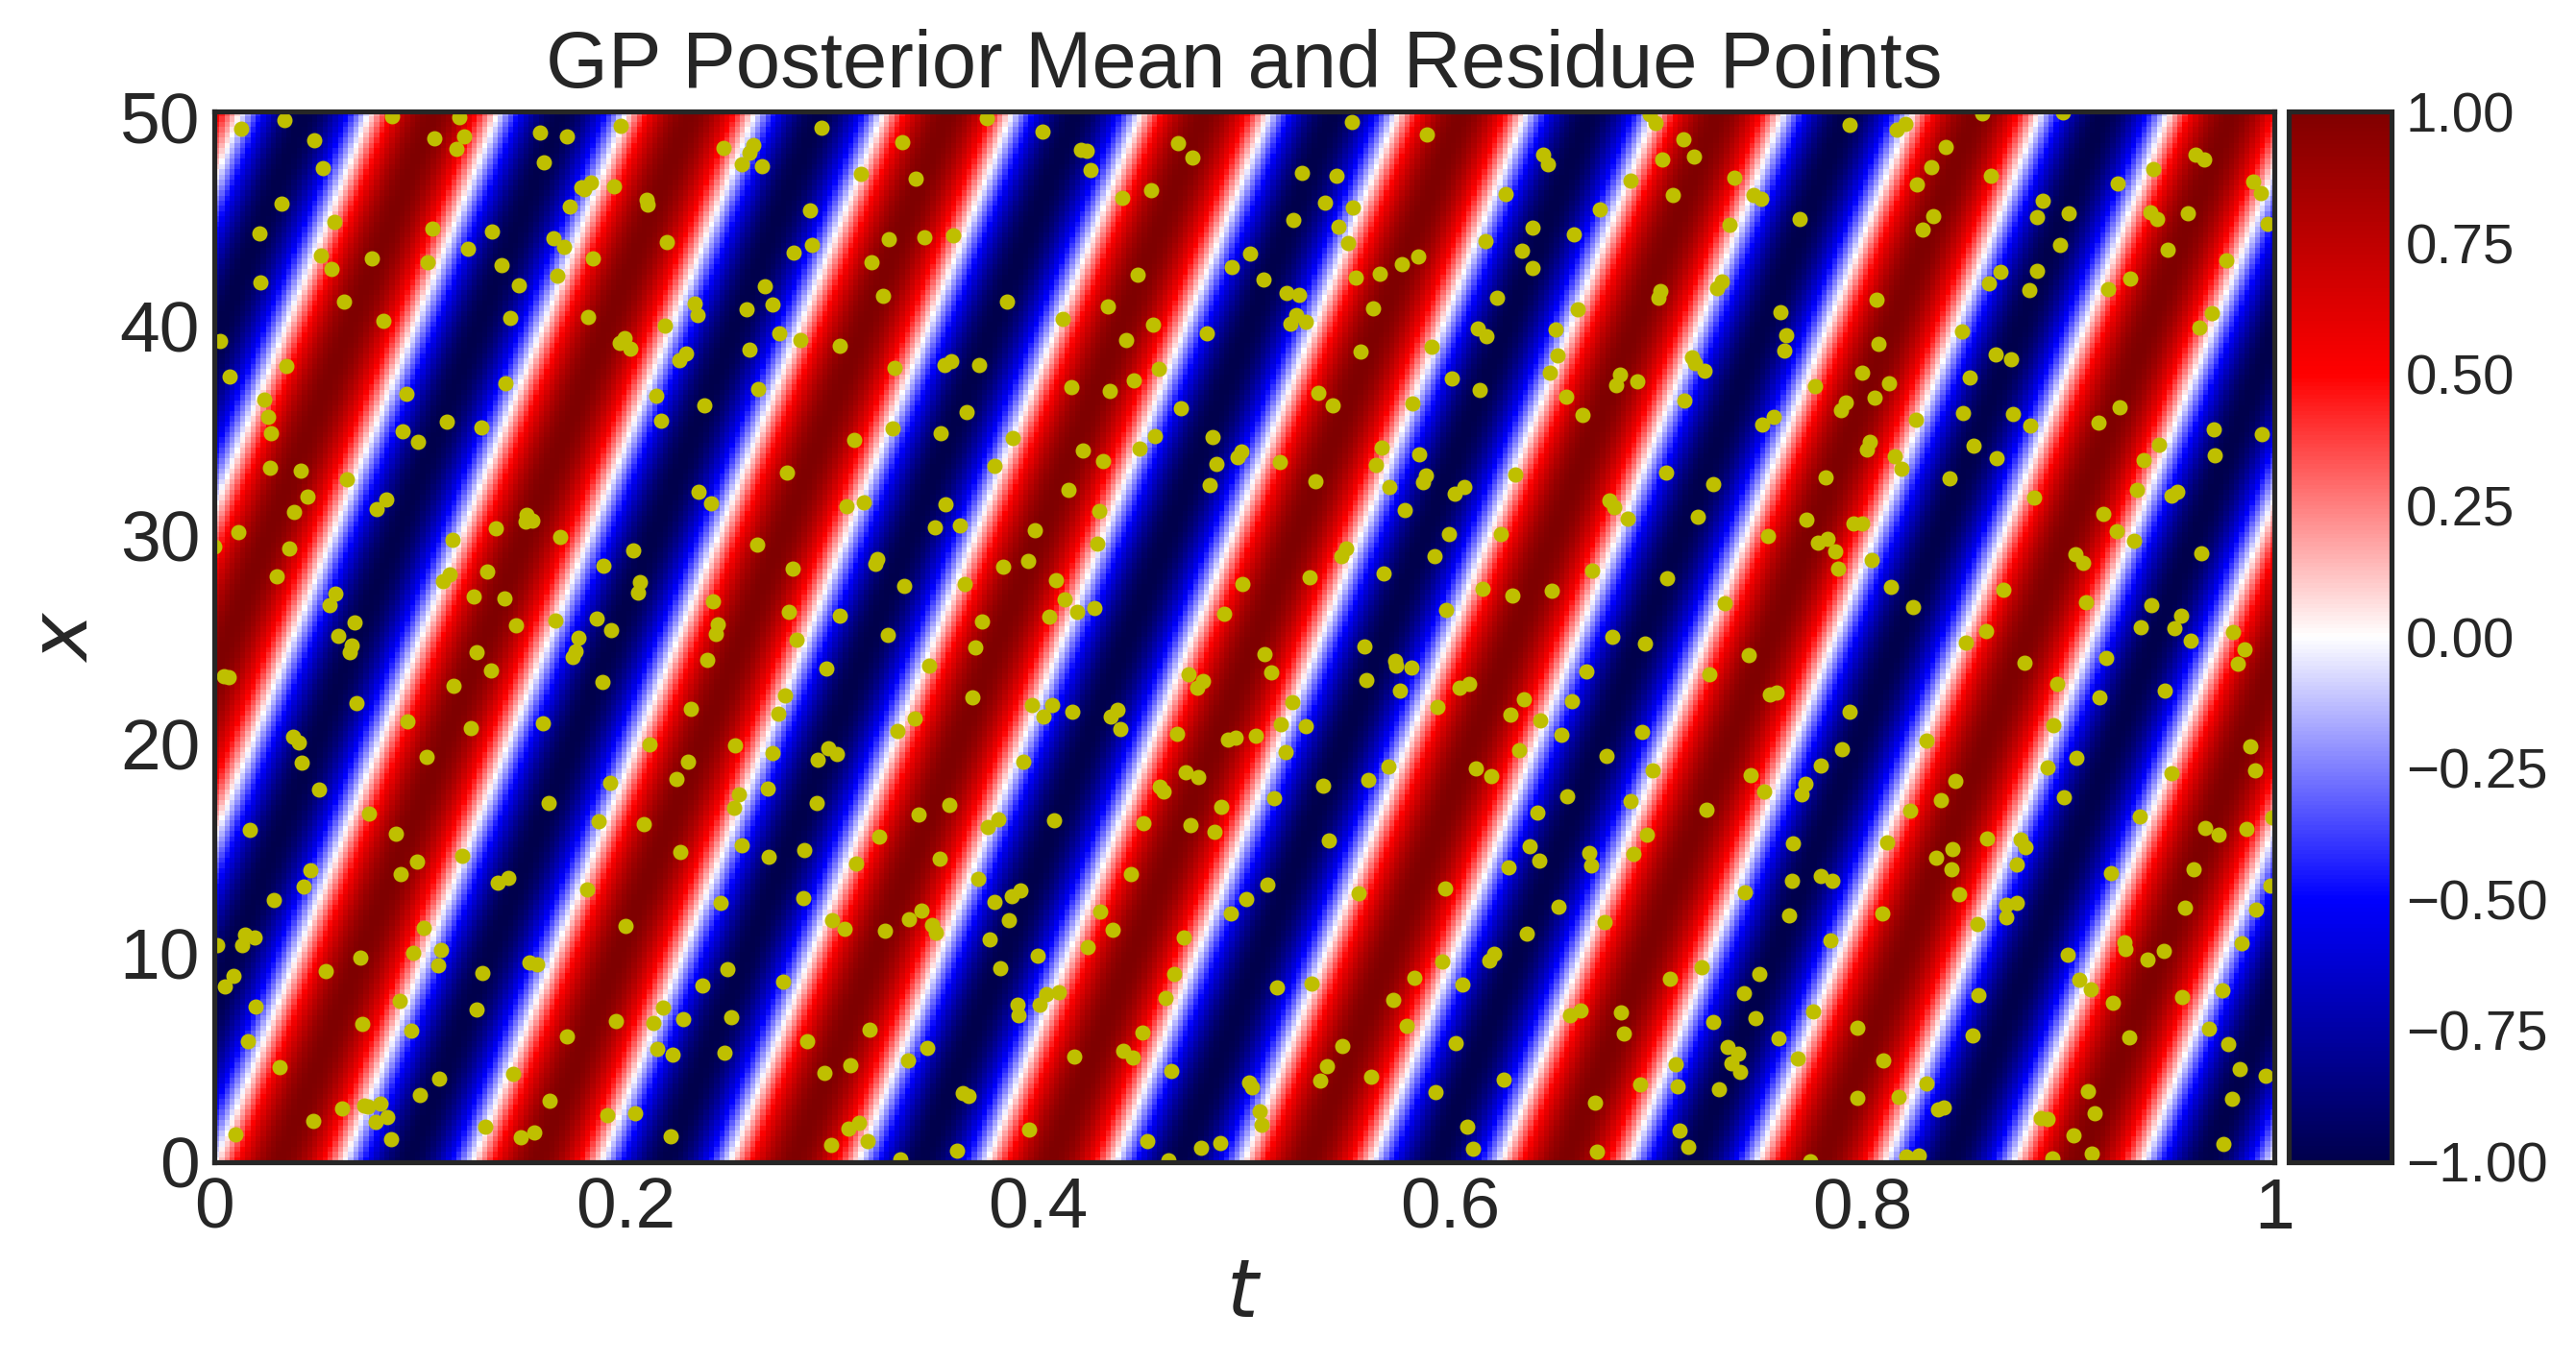

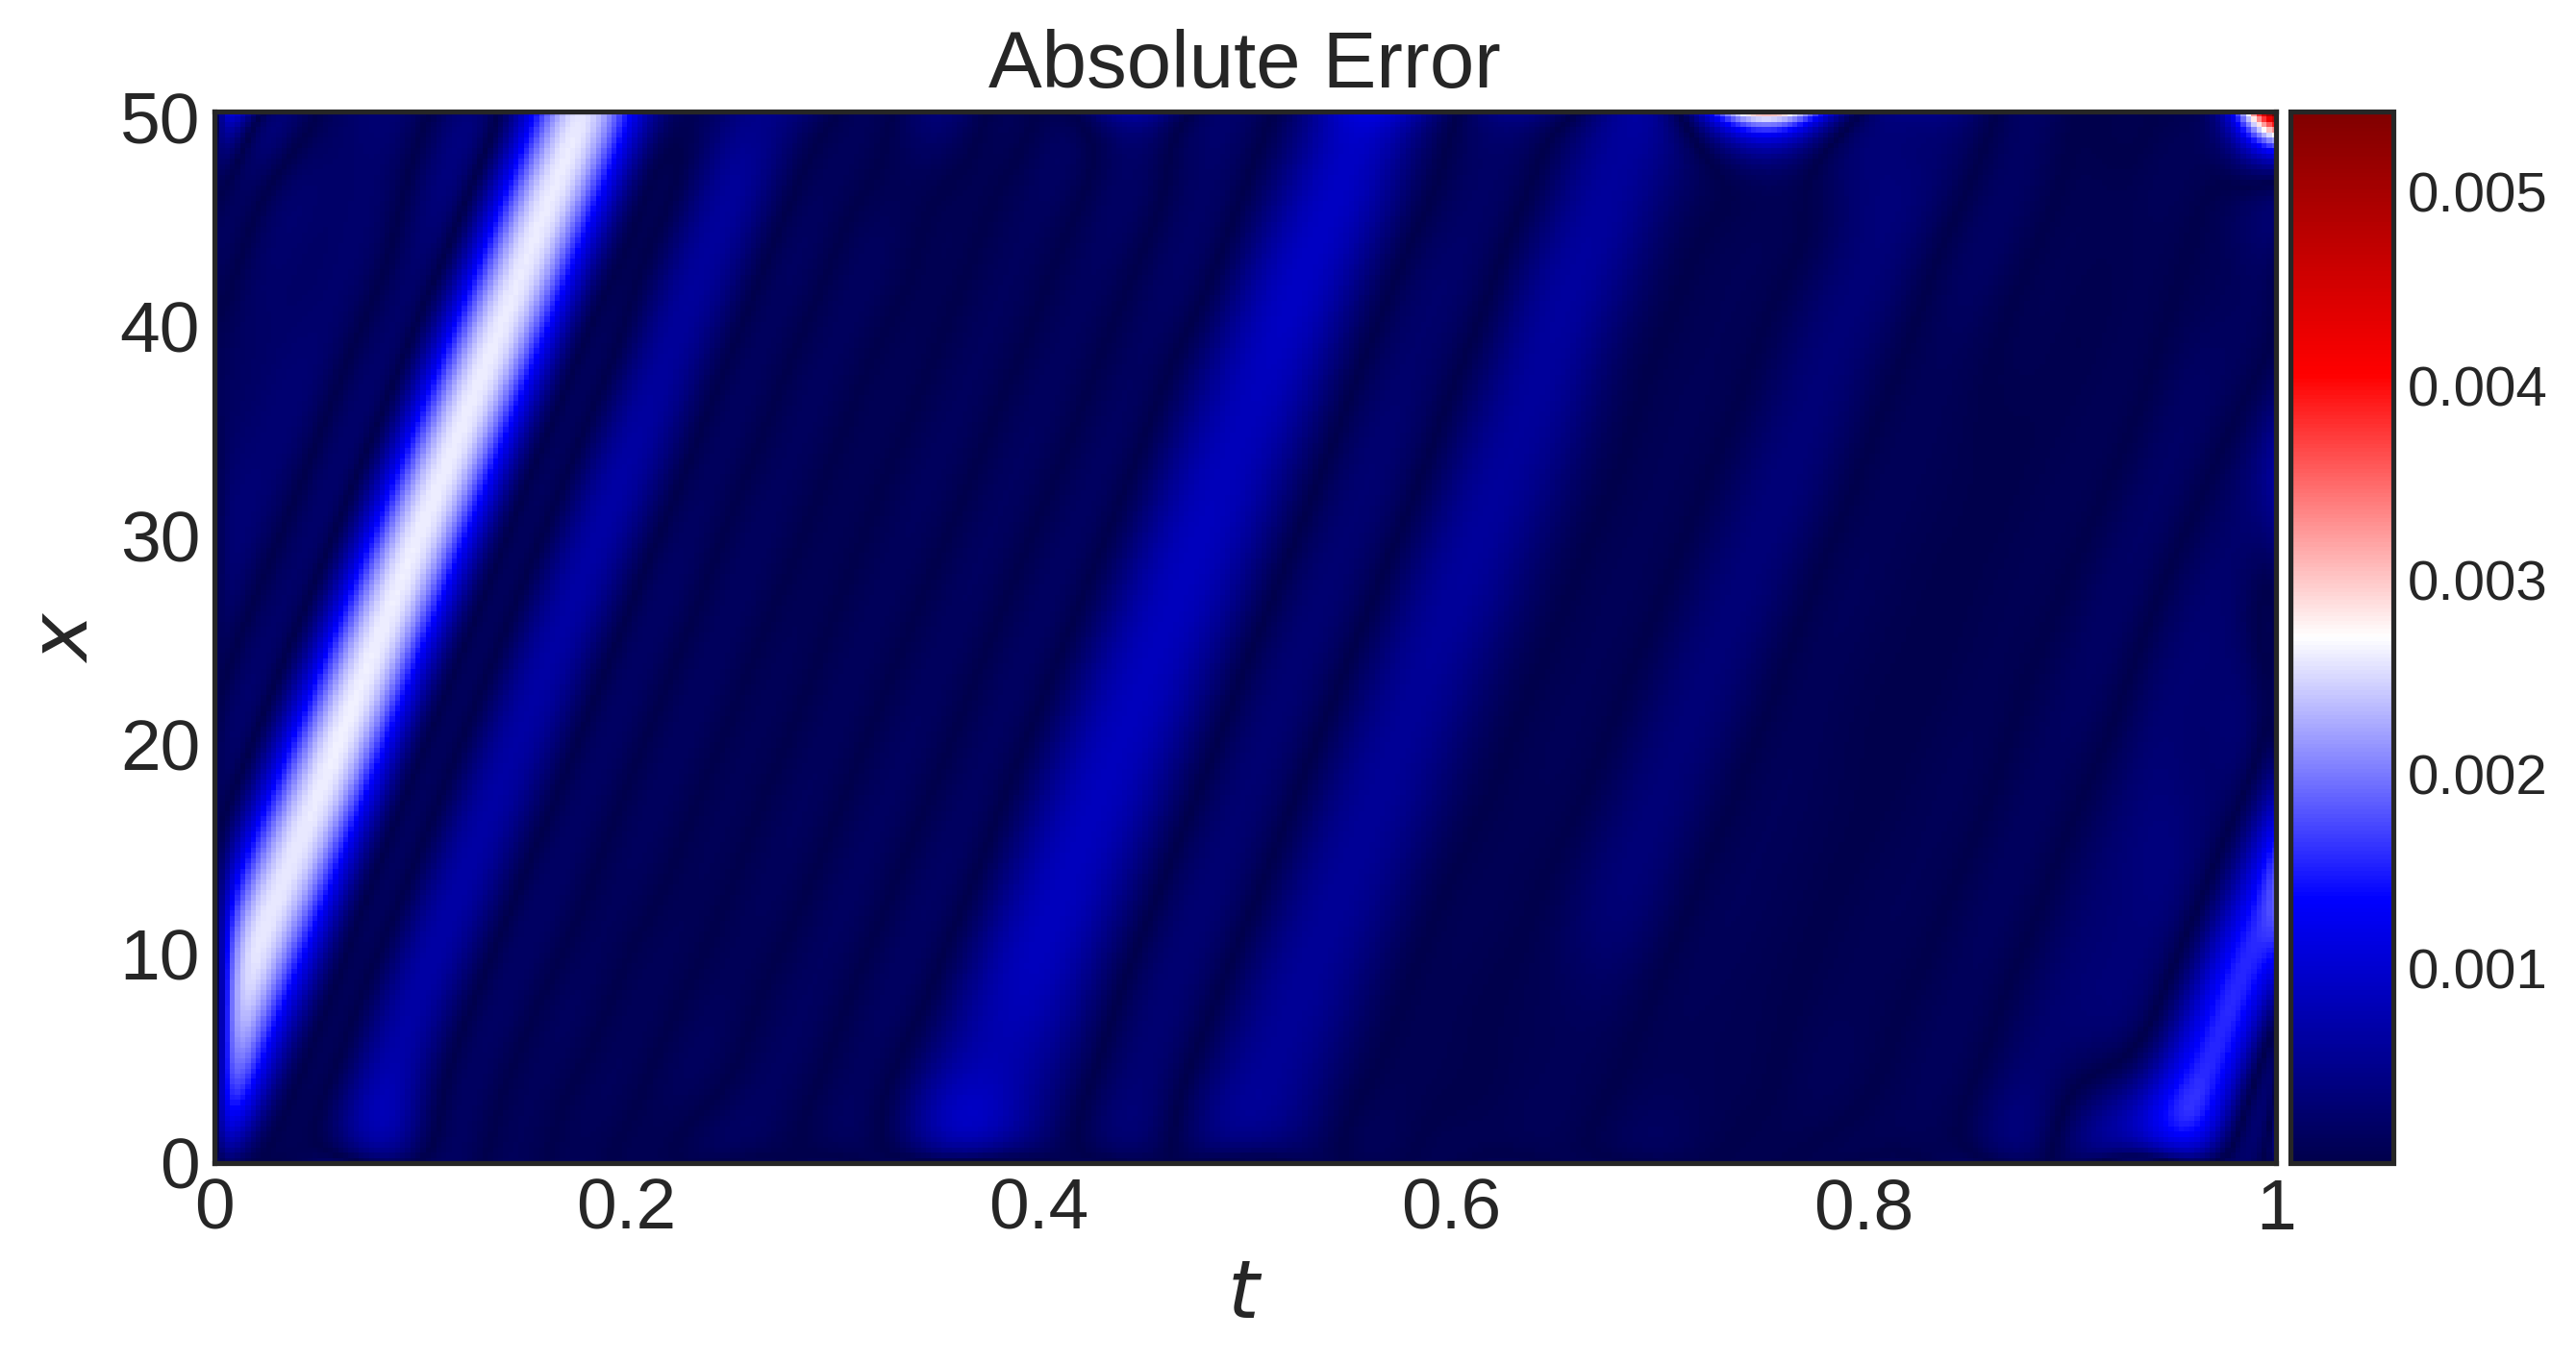

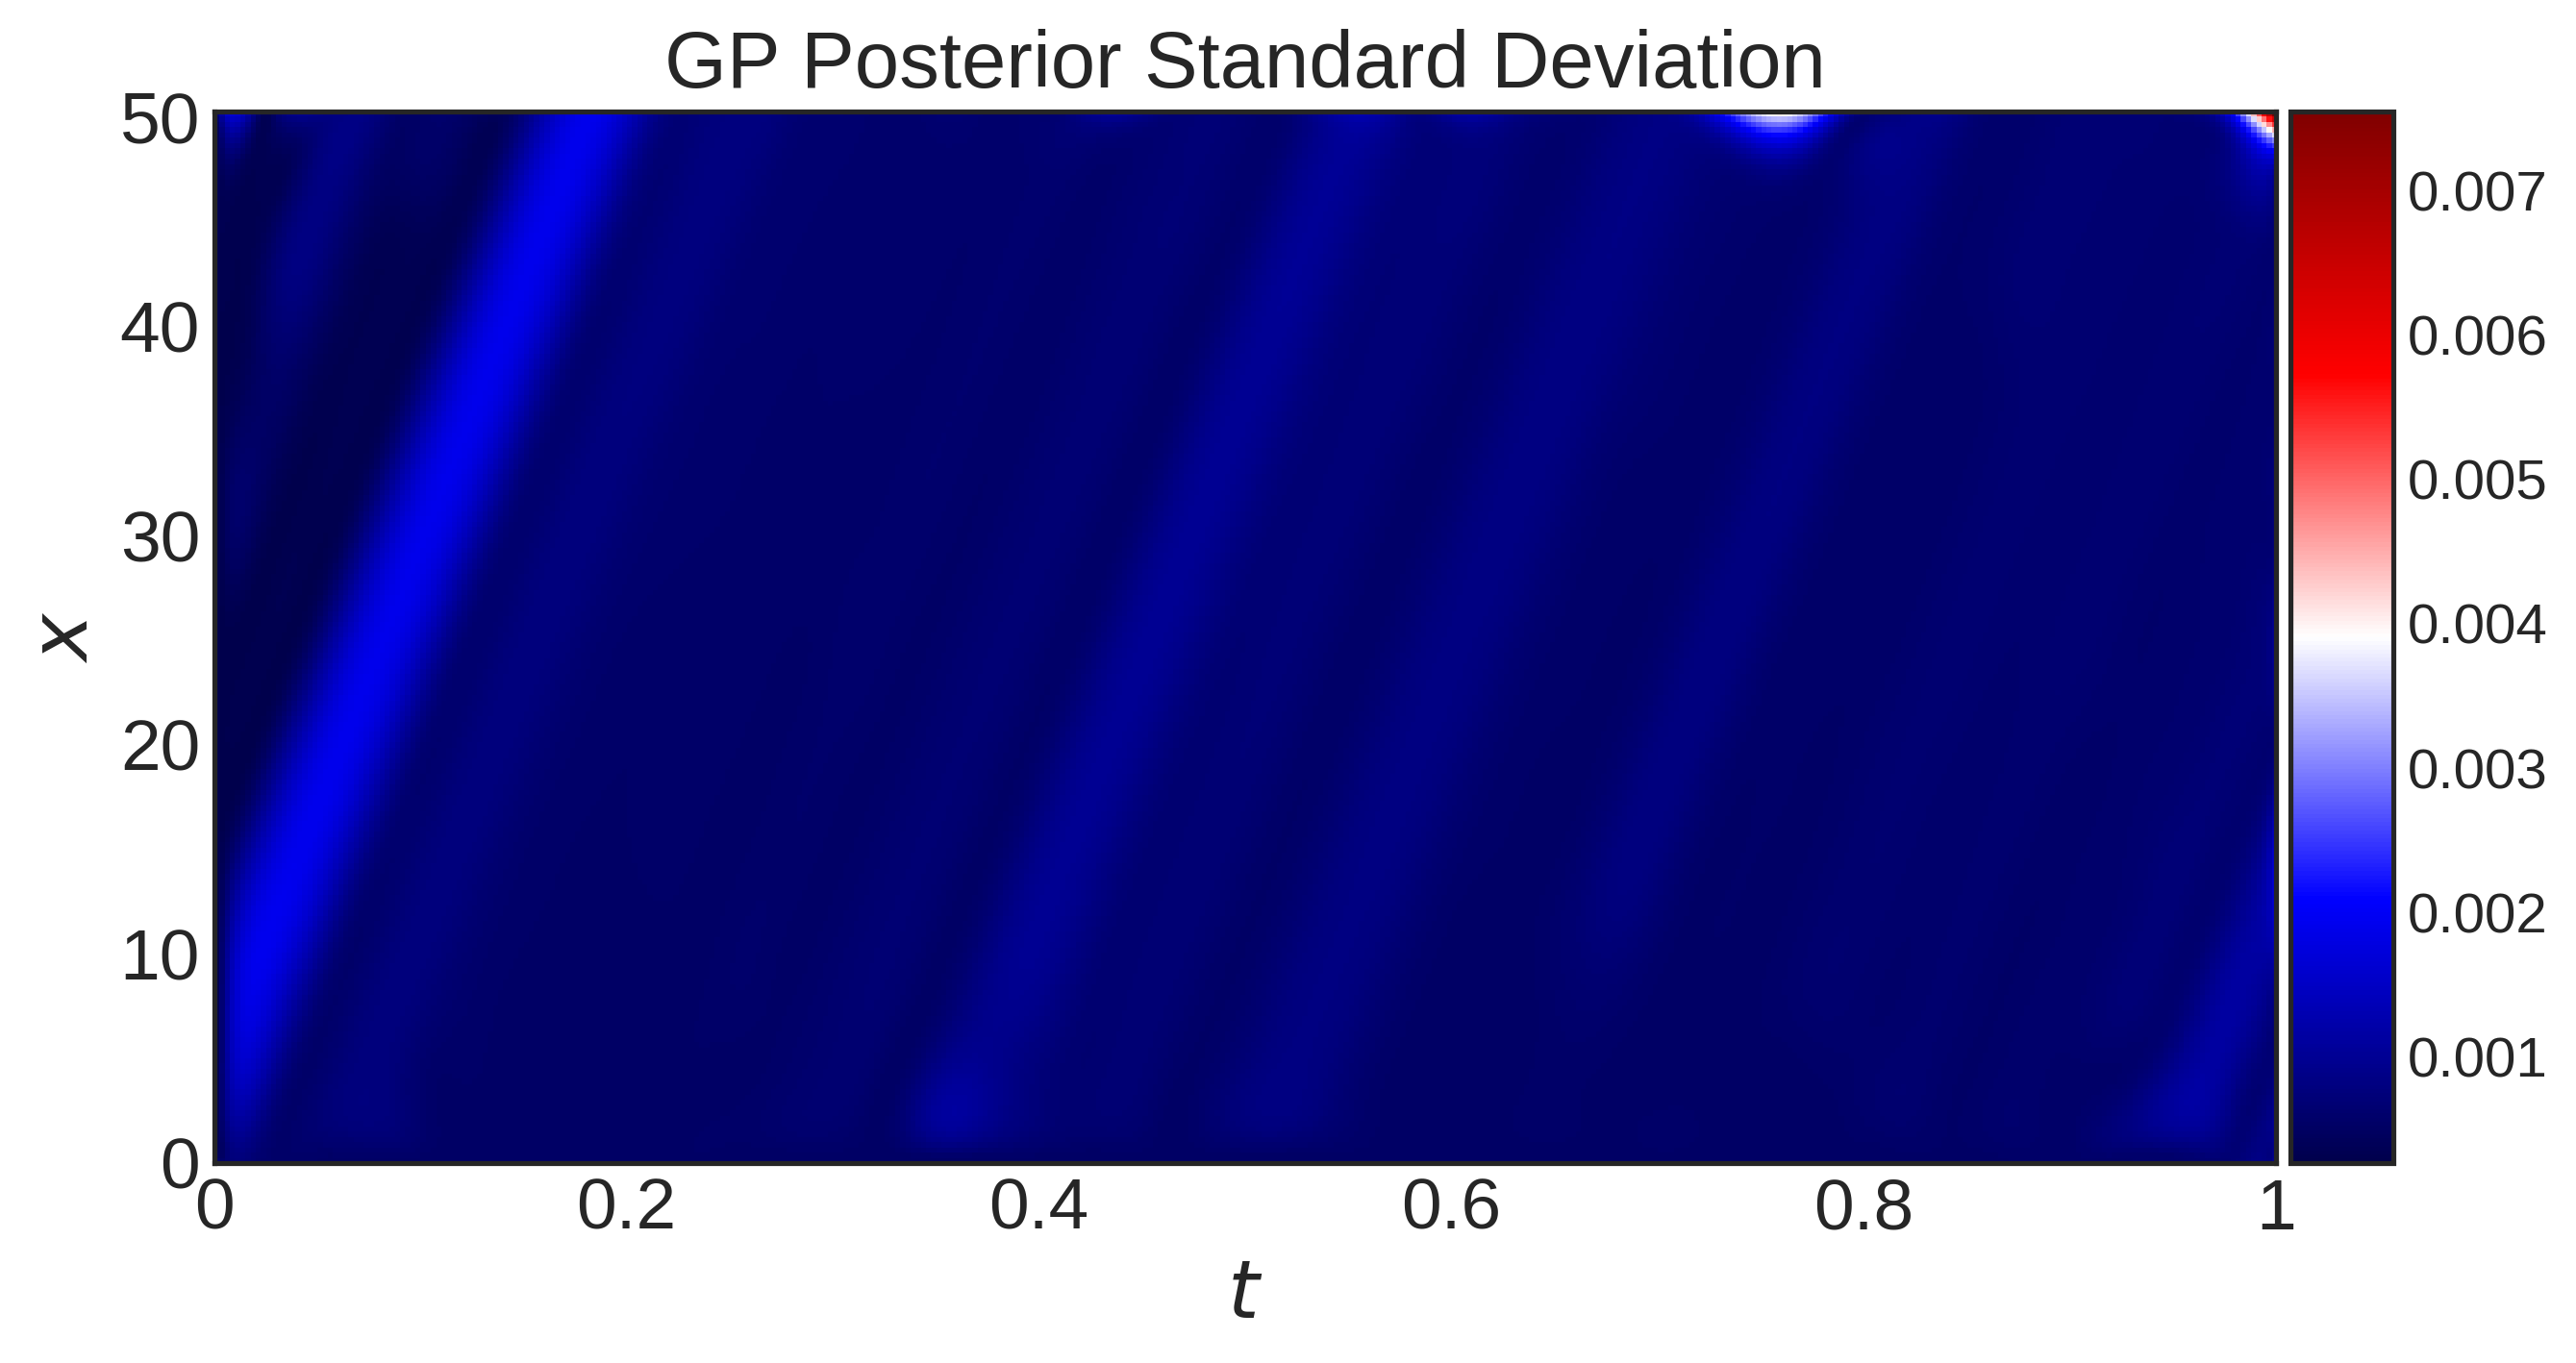

In [6]:
"""
Display results
"""

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                     # convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0          # aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale  # width in inches
    fig_height = nplots*fig_width*golden_mean     # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

# L2 error
err = np.linalg.norm(u_pm.T-u.T,2)/np.linalg.norm(u.T,2)
print('L2 error: %.4e' % (err))

# Exact
plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=figsize(2,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06,bottom=1-1/3,left=0.2,right=.9,wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(u,interpolation='nearest',cmap='seismic',
             extent=[ti,tf,xl,xr],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%",pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xticks(np.arange(0,1.01,0.2),labels=['0','0.2','0.4','0.6','0.8','1'])
ax.set_ylabel('$x$',fontsize=20)
ax.set_xlabel('$t$',fontsize=20)
ax.set_title('Exact',fontsize=20)
plt.show()

# Posterior Mean
plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=figsize(2,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06,bottom=1-1/3,left=0.2,right=.9,wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(u_pm,interpolation='nearest',cmap='seismic',
             extent=[ti,tf,xl,xr],origin='lower',aspect='auto')
plt.scatter(Z[:,1],Z[:,0],s=32,marker='.',color='y',alpha=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xticks(np.arange(0,1.01,0.2),labels=['0','0.2','0.4','0.6','0.8','1'])
ax.set_ylabel('$x$',fontsize=20)
ax.set_xlabel('$t$',fontsize=20)
ax.set_title('GP Posterior Mean and Residue Points',fontsize=20)
plt.show()

# |Posterior Mean - Exact|
plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=figsize(2,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06,bottom=1-1/3,left=0.2,right=.9,wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(np.abs(u_pm-u),interpolation='nearest',cmap='seismic',
             extent=[ti,tf,xl,xr],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xticks(np.arange(0,1.01,0.2),labels=['0','0.2','0.4','0.6','0.8','1'])
ax.set_ylabel('$x$',fontsize=20)
ax.set_xlabel('$t$',fontsize=20)
ax.set_title('Absolute Error',fontsize=20)
plt.show()

# Posterior Standard Deviation
plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=figsize(2,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06,bottom=1-1/3,left=0.2,right=.9,wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(u_sd,interpolation='nearest',cmap='seismic',
             extent=[ti,tf,xl,xr],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xticks(np.arange(0,1.01,0.2),labels=['0','0.2','0.4','0.6','0.8','1'])
ax.set_ylabel('$x$',fontsize=20)
ax.set_xlabel('$t$',fontsize=20)
ax.set_title('GP Posterior Standard Deviation',fontsize=20)
plt.show()